In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt  
!git clone https://github.com/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023

Cloning into 'PHYS3151-Machine-Learning-in-Physics-2023'...


In [32]:
# spin configurations
df1 = pd.read_csv("./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/conf.csv",header=None) 
# temperature
df2 = pd.read_csv("./PHYS3151-Machine-Learning-in-Physics-2023/principal-component-analysis/Ising_model/temp.csv",header=None)
df1 = df1.to_numpy()
df2 = df2.to_numpy()
x = df1
t = df2
t = t.T
# print(x)

In [33]:
z = np.zeros((x.shape))
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0,ddof=0)
for i in range(x.shape[1]):
  z[:,i]=x_mean[i]-x[:,i]
cov = np.cov(z,rowvar=False)

We can then factorise Z as $$Z = U.S.V^* $$
where S is a diagonal matrix whose diagonal entries are eigenvalues sorted in descending order, and U is a unitary matrix whose columns are corresponding eigenvectors.

In [34]:
from numpy import linalg as la
U,sigma,VT=la.svd(cov) # sigma is eigenvalue, U is eigenvector


We project the data onto the first **three** components. And plot our dimensionally reduced data.

In [35]:
U_reduced=U[ : , :3]
reduced_vec=np.dot(z,U_reduced)


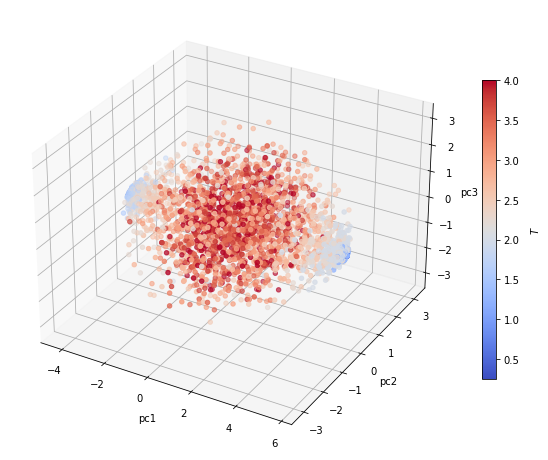

In [36]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(reduced_vec[:,0],reduced_vec[:,1],reduced_vec[:,2],c=t,cmap="coolwarm")

ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
cb = fig.colorbar(p, shrink=0.55)
cb.set_label(label='$T$',labelpad=10)